# Link prediction for NetworKit

In [1]:
from networkit import *
%matplotlib inline
import matplotlib.pyplot as plt

No module named 'seaborn'


In [2]:
cd ~/Thesis/NetworKit-Esders

/home/xza/Thesis/NetworKit-Esders


In [54]:
G = readGraph("input/jazz.graph", Format.METIS)

In [55]:
partitionedGraph = linkprediction.RandomEdgePartitioner(G).partitionByPercentage(0.1)
G.numberOfEdges()

2742

In [56]:
partitionedGraph[0].numberOfEdges()

2468

In [57]:
partitionedGraph[1].numberOfEdges()

274

In [73]:
katzIndex = linkprediction.KatzIndex(partitionedGraph[0], 4, 0.5)

In [74]:
dyadScorePairs = katzIndex.runAll()

In [75]:
roc = linkprediction.ROC(partitionedGraph[1], dyadScorePairs)
roc.generatePoints()
points = roc.getPoints()

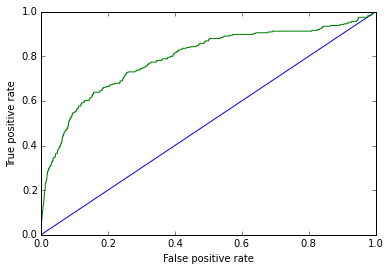

In [76]:
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot([0, 1], [0, 1])
plt.plot(points[0], points[1])

In [77]:
roc.areaUnderCurve()

0.7912217578434629

In [63]:
cn = linkprediction.CommonNeighborsIndex(partitionedGraph[0])

In [64]:
dyadScorePairsCN = cn.runAll()

In [65]:
rocCN = linkprediction.ROC(partitionedGraph[1], dyadScorePairsCN)
rocCN.generatePoints()
pointsCN = rocCN.getPoints()

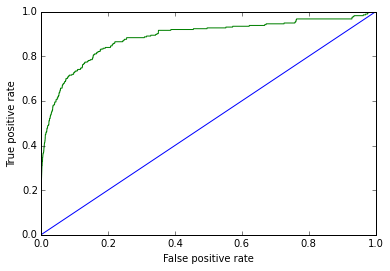

In [66]:
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot([0, 1], [0, 1])
plt.plot(pointsCN[0], pointsCN[1])

In [67]:
rocCN.areaUnderCurve()

0.8846585987542913